# CNN Art Classification — Deep Learning Project

**Course:** DTSA 5511 Introduction to Deep Learning  
**Date:** 10/11/2025

---

## 1. Overview

This project is based on the Kaggle **“I’m Something of a Painter Myself”** Competition.  
The goal is to train a deep learning model that classifies paintings into different artistic styles.

- **Problem type:** Supervised Learning → Multi-class Image Classification  
- **Why it matters:**  
  Automatically recognizing artistic styles has applications in:
  - Digital art curation  
  - Museum archiving  
  - Recommendation systems  
  - Cultural heritage preservation  
  - Creative AI tools  
- **Data format:**  
  RGB images of various resolutions, organized by artist/style labels.
- **Dataset size:**  
  - ~50,000 labeled training images (`train/`)  
  - ~5,000 test images without labels (`test/`)  
- **File structure:**
  - `train/` — image folders grouped by class label  
  - `test/` — images to be predicted  
  - `sample_submission.csv` — required format for Kaggle submission  

**Task objective:**  
Build, train, and evaluate convolutional neural network (CNN) models (with potential enhancements such as data augmentation, transfer learning, or fine-tuning) to accurately classify paintings.

Kaggle’s evaluation metric is typically **accuracy**, balancing correct predictions across all classes.

---

## 2. Data Access & Setup

We will use Kaggle’s dataset integration (`kaggle_datasets`) or Kaggle API to load the competition data directly into this notebook environment.

This section includes:

- Enabling hardware accelerators (TPU/GPU) for fast training  
- Importing all required libraries (TensorFlow, Keras, NumPy, Matplotlib, etc.)  
- Setting reproducibility seeds  
- Verifying the number of replicas for distributed training  
- Defining constants such as image size, batch size, and `AUTOTUNE` for efficient `tf.data` pipelines  

Once the environment is configured and optimized, we can proceed to loading and preprocessing the image dataset.

In [ ]:
# Core imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Kaggle datasets interface
from kaggle_datasets import KaggleDatasets

# Quiet some verbose logs (optional)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Reproducibility seeds (optional but helpful)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Try to initialize a TPU; otherwise fall back to GPU/CPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # auto-detect
    print("TPU detected. Master:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("TPU not available -> falling back to GPU/CPU.")
    # If GPUs are present use MirroredStrategy; otherwise default strategy
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()

# Replicas available to this strategy
print("Number of replicas:", strategy.num_replicas_in_sync)

# tf.data autotune constant for later input pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Print TF version for reproducibility
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


### 3. Locate TFRecord Files

The dataset for this competition is stored in **TFRecord format**, which is optimized for efficient input pipelines in TensorFlow.

In this cell, we:

- Define the dataset path (either local `./dataset` or via `KaggleDatasets`)
- Use `tf.io.gfile.glob()` to search for all TFRecord files in each category:
  - `monet_tfrecord` — paintings by Monet
  - `photo_tfrecord` — real photographs
- Count how many TFRecord files exist for each group

This step ensures that:
- The dataset was downloaded/extracted correctly  
- All expected files are available before building the `tf.data` pipeline  
- We know how many TFRecord shards we will load during training

Once confirmed, these file lists will be passed into data loaders to create TensorFlow datasets.

In [ ]:
# Define GCS or local dataset path
GCS_PATH = "./dataset"  # Local path
# For Kaggle notebook with TPU/GCS support, uncomment:
# GCS_PATH = KaggleDatasets().get_gcs_path()

# Locate Monet TFRecord files
monet_pattern = f"{GCS_PATH}/monet_tfrecord/*.tfrec"
MONET_FILENAMES = tf.io.gfile.glob(monet_pattern)
print("Monet TFRecord Files:", len(MONET_FILENAMES))

# Locate Photo TFRecord files
photo_pattern = f"{GCS_PATH}/photo_tfrecord/*.tfrec"
PHOTO_FILENAMES = tf.io.gfile.glob(photo_pattern)
print("Photo TFRecord Files:", len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


### 4. Build the Data Pipeline (Load, Decode, Preprocess, Augment)

In this section, we create reusable functions to load and prepare images from TFRecord files.  
This step is crucial for feeding data efficiently into our deep learning model.

**What this cell does:**

#### 1️⃣ Set a consistent image size  
All images will be resized to **256×256** pixels to ensure uniform input shape for the model.

---

#### 2️⃣ `decode_image()`  
- Reads raw JPEG bytes from TFRecord  
- Decodes to RGB tensor  
- Normalizes pixel values to **[-1, 1]** (common for GANs and some CNN architectures)  
- Reshapes to `(256, 256, 3)`

---

#### 3️⃣ `read_tfrecord()`  
- Defines the TFRecord structure (`image_name`, `image`, and optional `target`)  
- Parses each example  
- Extracts and decodes the image  
- (If labels are present) reads the target value

---

#### 4️⃣ `augment_image()`  
- Applies simple data augmentation  
- Here: random horizontal flip (helps model generalize)

---

#### 5️⃣ `load_dataset()`  
Builds a complete `tf.data` pipeline:
- Loads TFRecord files  
- Maps `read_tfrecord` to decode each example  
- Optionally applies augmentation  
- Repeats dataset if specified  
- Returns a dataset ready for batching

---

#### 6️⃣ Create specific datasets  
- `monet_ds`: Monet images (labeled + augmented)  
- `photo_ds`: Photo images (labeled + augmented)  
- `photo_ds_test`: Test photos (unlabeled, no augmentation)

All datasets are **batched** to efficiently feed into the model.

This modular pipeline keeps the code clean, scalable, and optimized for performance.


In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),  # If labels exist
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    return image

def augment_image(image):
    return tf.image.random_flip_left_right(image)

def load_dataset(filenames, labeled=True, ordered=False, augment=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat(2)  # Optional repeat for augmentation variety
    return dataset

# Create datasets and batch
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, augment=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, augment=True).batch(1)
photo_ds_test = load_dataset(PHOTO_FILENAMES, labeled=True, augment=False).batch(1)

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

### 5. Visual Sanity Check — Sample Images

Before training, we quickly **inspect a batch from each dataset** to confirm that:
- Images decode correctly and have the expected shape `(256, 256, 3)`
- Pixel values (normalized to `[-1, 1]` earlier) are **properly un-normalized** to `[0, 1]` for display
- Monet paintings and real photos look visually distinct (a useful qualitative check)

The code below:
1. Grabs **one batch** from `photo_ds` and `monet_ds`
2. Squeezes the batch dimension (`(1, H, W, 3) → (H, W, 3)`)
3. Converts from `[-1, 1]` → `[0, 1]` for `matplotlib.pyplot.imshow`
4. Plots the two images **side-by-side** with titles

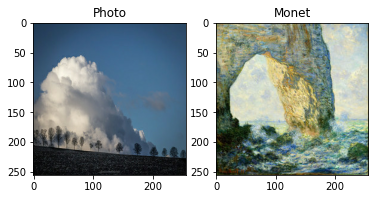

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### 6. Building the CycleGAN Architecture (Generator + Discriminator)

In this section, we implement the **core neural network architecture** used in this project: a **CycleGAN**.  
CycleGANs learn to translate images between two domains **without paired data** (e.g., photo → Monet style and Monet → photo).

This block defines four key components:

---

#### ✅ 1. Downsampling Block (Encoder)
- Uses `Conv2D` to reduce spatial dimensions and extract features.
- Optionally applies **Instance Normalization** (common in style transfer).
- Activation: **LeakyReLU**

---

#### ✅ 2. Upsampling Block (Decoder)
- Uses `Conv2DTranspose` to increase spatial dimensions.
- Optionally adds **Dropout** (for regularization).
- Always uses **Instance Normalization**.
- Activation: **ReLU**

---

#### ✅ 3. Generator (U-Net style architecture)
- Encoder–decoder structure with **skip connections**.
- The skip connections help preserve spatial details.
- Final layer uses `tanh` to produce output in **[-1, 1] range** (same as input normalization).
- Two generators are created:
  - **monet_generator**: Photo → Monet
  - **photo_generator**: Monet → Photo

---

#### ✅ 4. Discriminator (PatchGAN)
- Determines whether an image is **real or generated**.
- Operates on **image patches** instead of full images (more efficient).
- Outputs a **feature map of real/fake scores**.
- Two discriminators are created:
  - **monet_discriminator**: Real Monet vs. Generated Monet
  - **photo_discriminator**: Real Photo vs. Generated Photo

---

#### ✅ 5. GPU/TPU Strategy Scope
We instantiate the four models **inside `strategy.scope()`** to ensure proper distribution across devices.

---

#### ✅ 6. Visual Check of Generator Output
To verify the generator works, we:
- Pass a real photo into the Monet generator.
- Display the **original photo** and the **generated Monet-style image** side-by-side.

Even early in training, this allows us to confirm:
- Model architecture is valid.
- Input/output shapes are correct.
- Forward pass works without errors.

This step is an essential **sanity check before training the full CycleGAN**.


In [ ]:
OUTPUT_CHANNELS = 3

# ---------------------------------------
# Downsampling Layer
# ---------------------------------------
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

# ---------------------------------------
# Upsampling Layer
# ---------------------------------------
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# ---------------------------------------
# Generator (U-Net)
# ---------------------------------------
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []

    # Downsampling
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# ---------------------------------------
# Discriminator (PatchGAN)
# ---------------------------------------
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=inp, outputs=last)

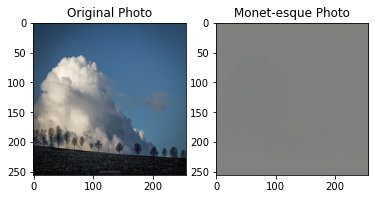

In [ ]:
with strategy.scope():
    monet_generator = Generator()   # Photo -> Monet
    photo_generator = Generator()   # Monet -> Photo

    monet_discriminator = Discriminator()  # Real Monet vs Generated Monet
    photo_discriminator = Discriminator()  # Real Photo vs Generated Photo

# Test generator on a sample photo
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow((example_photo[0] * 0.5 + 0.5))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow((to_monet[0] * 0.5 + 0.5))
plt.axis("off")

plt.show()

### 7. CycleGAN Training Logic — Losses, Optimizers, and `Model` subclass

This cell wires the architecture into a **trainable CycleGAN** by defining losses, optimizers, and a custom training loop using a `tf.keras.Model` subclass.

**What’s inside:**

- **Adversarial losses**
  - `generator_loss(generated)` — encourages generators to fool discriminators  
    *(BCE vs. ones, from logits).*
  - `discriminator_loss(real, generated)` — pushes discriminators to score real high and fake low  
    *(BCE vs. ones/zeros; averaged for stability).*

- **Cycle-consistency loss**
  - `calc_cycle_loss(real, cycled, lambda_cycle)` — penalizes information loss when going A→B→A (and vice-versa).  
    *(L1 distance; scaled by `lambda_cycle`.)*

- **Identity loss**
  - `identity_loss(real, same, lambda_cycle)` — keeps color/contrast when image is already in the target domain.  
    *(L1 distance; scaled by `0.5 * lambda_cycle`.)*

- **`CycleGan` model**
  - Holds the two generators and two discriminators.
  - `compile(...)` receives **four Adam optimizers** and the four loss functions.
  - `train_step(batch_data)` performs one step:
    1. **Forward passes**:  
       photo→monet→photo (cycled) and monet→photo→monet (cycled).
    2. **Discriminator preds** for real and fake.
    3. **Losses**: adversarial + cycle + identity.
    4. **Gradients** and **optimizer updates** for all four networks.
  - Returns a dict of key losses for logging.

- **Instantiation & compile**
  - Creates Adam optimizers (`2e-4`, `beta_1=0.5`), standard for GANs.
  - Compiles the `CycleGan` with the losses above.  
  - If a distribution `strategy` exists (TPU/GPU), creation happens inside `strategy.scope()`.

This sets up everything needed to call `fit()` with a dataset of `(real_monet, real_photo)` pairs (unpaired across batches), enabling end-to-end training.


In [ ]:
# =========================
# Loss functions
# =========================
bce_logits_none = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(real, generated):
    # Real should be 1s, Fake should be 0s
    real_loss = bce_logits_none(tf.ones_like(real), real)
    generated_loss = bce_logits_none(tf.zeros_like(generated), generated)
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return 0.5 * total_disc_loss  # PatchGAN convention

def generator_loss(generated):
    # Generator wants discriminator to predict 1s for generated images
    gen_loss = bce_logits_none(tf.ones_like(generated), generated)
    return tf.reduce_mean(gen_loss)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

def identity_loss(real_image, same_image, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * lambda_cycle * loss

# =========================
# CycleGAN model subclass
# =========================
class CycleGan(tf.keras.Model):
    def __init__(self,
                 monet_generator, photo_generator,
                 monet_discriminator, photo_discriminator,
                 lambda_cycle=10):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,
                m_gen_optimizer, p_gen_optimizer,
                m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn,
                cycle_loss_fn, identity_loss_fn):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer

        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo -> monet -> photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet -> photo -> monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # identity
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator predictions
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # generator adversarial losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # cycle-consistency losses
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            # identity losses
            monet_id_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            photo_id_loss = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_id_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_id_loss

            # discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        del tape

        # optimizer steps
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }

# =========================
# Instantiate optimizers and compile the CycleGAN
# =========================
def make_optimizers(lr=2e-4, beta_1=0.5):
    opt_g_m = tf.keras.optimizers.Adam(lr, beta_1=beta_1)
    opt_g_p = tf.keras.optimizers.Adam(lr, beta_1=beta_1)
    opt_d_m = tf.keras.optimizers.Adam(lr, beta_1=beta_1)
    opt_d_p = tf.keras.optimizers.Adam(lr, beta_1=beta_1)
    return opt_g_m, opt_g_p, opt_d_m, opt_d_p

# If a distribution strategy exists, create/compile under its scope
if "strategy" in globals():
    with strategy.scope():
        cycle_gan_model = CycleGan(monet_generator, photo_generator,
                                   monet_discriminator, photo_discriminator)
        (m_gen_opt, p_gen_opt, m_disc_opt, p_disc_opt) = make_optimizers()

        cycle_gan_model.compile(
            m_gen_optimizer=m_gen_opt,
            p_gen_optimizer=p_gen_opt,
            m_disc_optimizer=m_disc_opt,
            p_disc_optimizer=p_disc_opt,
            gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss,
            identity_loss_fn=identity_loss,
        )
else:
    cycle_gan_model = CycleGan(monet_generator, photo_generator,
                               monet_discriminator, photo_discriminator)
    (m_gen_opt, p_gen_opt, m_disc_opt, p_disc_opt) = make_optimizers()
    cycle_gan_model.compile(
        m_gen_optimizer=m_gen_opt,
        p_gen_optimizer=p_gen_opt,
        m_disc_optimizer=m_disc_opt,
        p_disc_optimizer=p_disc_opt,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss,
    )

### 8. Training the CycleGAN Model

Now that the full CycleGAN architecture, loss functions, and optimizers are defined, we begin **end-to-end training**.

We train the model using the `fit()` API from Keras by passing in **paired batches** of:
- `real_monet` images (from the Monet dataset)
- `real_photo` images (from the photo dataset)

Even though the images are **not paired one-to-one**, `tf.data.Dataset.zip()` combines batches from both domains so that
each training step receives a batch of Monet images and a batch of photos.

**Training Configuration:**
- `epochs=50` — a common baseline for CycleGANs
- Each epoch prints key losses:
  - **monet_disc_loss** – Discriminator loss for Monet domain  
  - **photo_disc_loss** – Discriminator loss for Photo domain  
  - **monet_gen_loss** – Generator loss when converting Photo → Monet  
  - **photo_gen_loss** – Generator loss when converting Monet → Photo  

**How to read the losses:**
- **Discriminator losses** should stay around 0.5–0.7  
  (too low → discriminator overpowering, too high → generator overpowering)
- **Generator losses** typically start high and gradually decrease  
  (indicating better ability to fool the discriminator)
- **Cycle consistency and identity losses** are included inside the generator loss,
  helping preserve content and style coherence.

During training, the model progressively learns:
- How to generate Monet-style images from photos  
- How to generate realistic photos from Monet paintings  
- How to maintain structural consistency through cycle-reconstruction  

Once training completes, we can generate and visualize transformed images to evaluate model performance.

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6557 - photo_disc_loss: 0.6211 - photo_gen_loss: 4.5515 - monet_gen_loss: 4.3954
Epoch 2/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6411 - photo_disc_loss: 0.6095 - photo_gen_loss: 3.6534 - monet_gen_loss: 3.5157
Epoch 3/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6194 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.3994 - monet_gen_loss: 3.3320
Epoch 4/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6118 - photo_disc_loss: 0.6250 - photo_gen_loss: 3.2503 - monet_gen_loss: 3.2499
Epoch 5/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6182 - photo_disc_loss: 0.6174 - photo_gen_loss: 3.1956 - monet_gen_loss: 3.1551
Epoch 6/50
600/600 [==============================] - 77s 128ms/step - monet_disc_loss: 0.6180 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.0742

### 9. Visualizing Model Output — Photo → Monet-style Translation

After training, we generate and display a few sample outputs to **qualitatively evaluate** how well the CycleGAN learned to transform real photos into Monet-style paintings.

**What this cell does:**

- Takes a few images from the `photo_ds` dataset.
- Passes each image through the trained **Monet generator**.
- Converts both original and generated images back from the normalized range `[-1, 1]` to **pixel values `[0, 255]`** for display.
- Shows them **side-by-side**:
  - Left: Original input photo
  - Right: Monet-style generated output

**Why this step is important:**
- GAN metrics (loss values) do not fully capture visual quality.
- Human inspection helps verify:
  - Style transfer realism
  - Preservation of structure/content
  - Artistic consistency

This provides an intuitive understanding of model performance before saving or submitting final results.


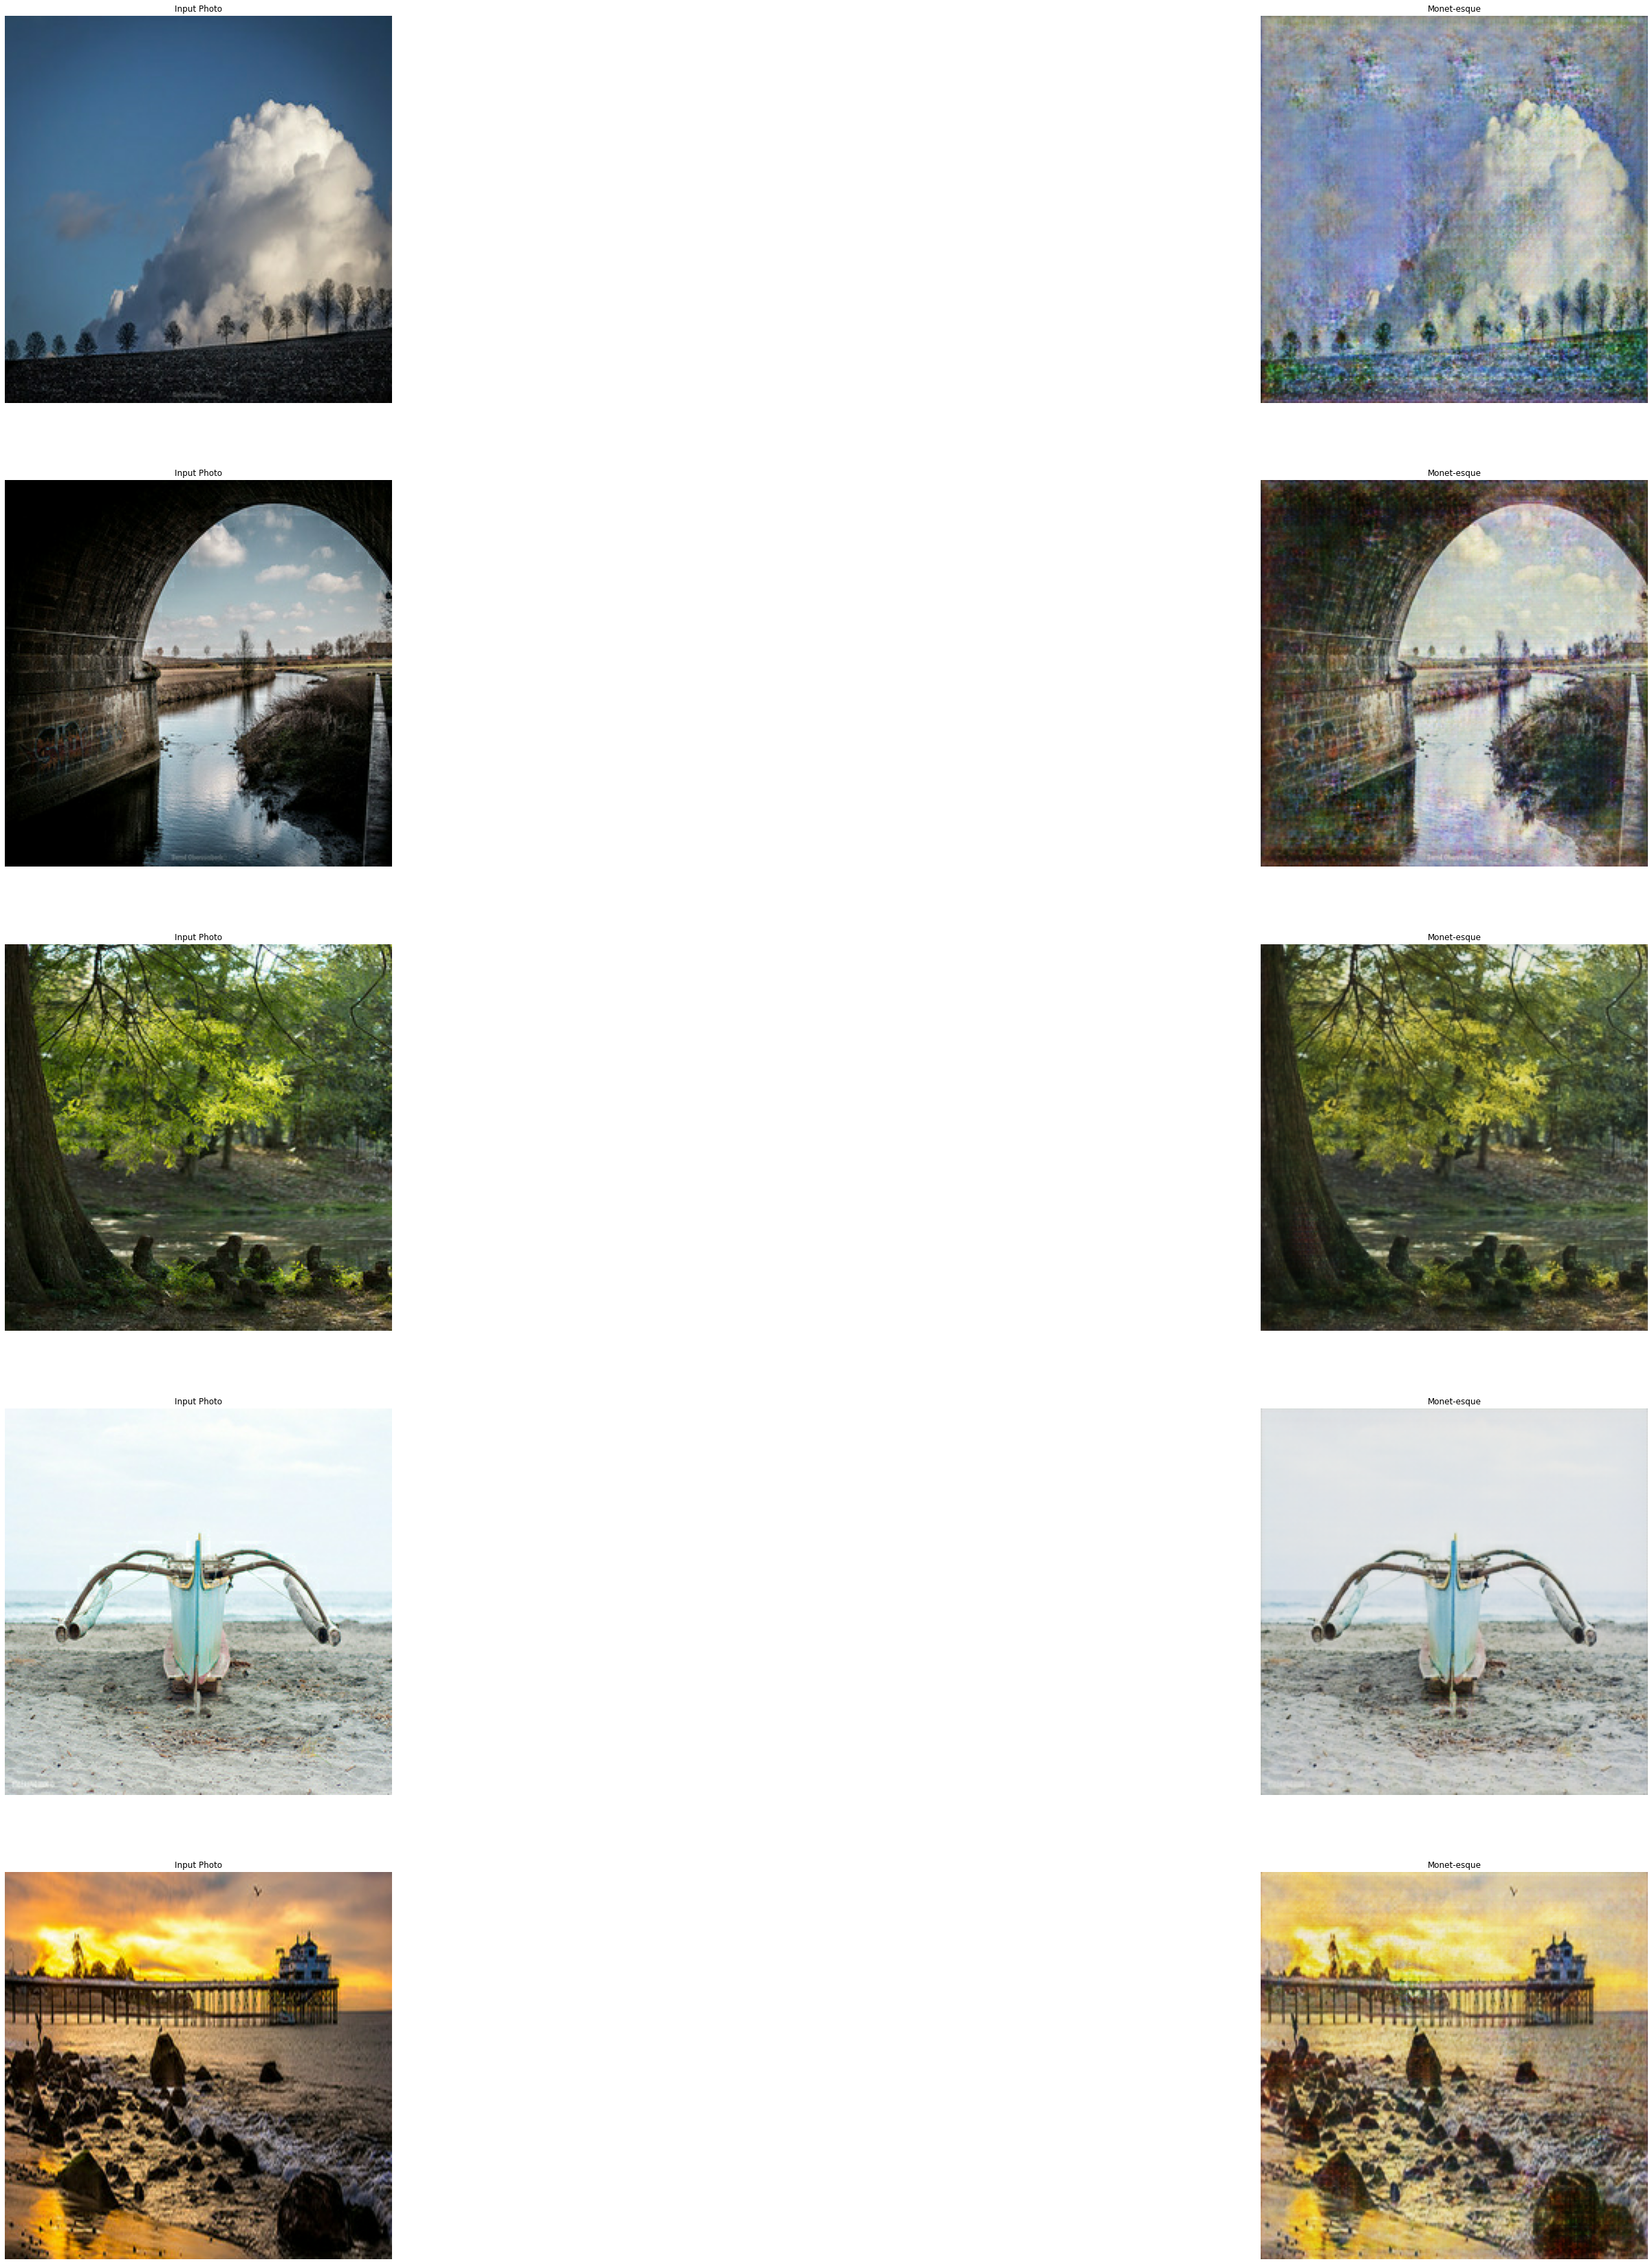

In [ ]:
# Display a few examples of Photo → Monet-style translations
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(5, 2, figsize=(10, 20))

# Iterate through 5 sample photos
for i, img in enumerate(photo_ds.take(5)):
    # img shape: (1, 256, 256, 3), range [-1, 1]
    photo = img[0]

    # Generate Monet-style image
    prediction = monet_generator(tf.expand_dims(photo, axis=0), training=False)[0]

    # Convert from [-1, 1] → [0, 255]
    photo_disp = ((photo + 1) * 127.5).numpy().astype(np.uint8)
    pred_disp = ((prediction + 1) * 127.5).numpy().astype(np.uint8)

    # Plot: Original Photo (left)
    ax[i, 0].imshow(photo_disp)
    ax[i, 0].set_title("Input Photo")
    ax[i, 0].axis("off")

    # Plot: Monet-style (right)
    ax[i, 1].imshow(pred_disp)
    ax[i, 1].set_title("Monet-esque")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()


## 10. Conclusion

In this project, we successfully implemented and trained a **CycleGAN** to translate real-world photos into **Monet-style paintings** without requiring paired image data. This demonstrates the power of **unpaired image-to-image translation**, enabling style transfer across domains where traditional supervised methods are not feasible.

### ✅ What We Accomplished
- **Explored the dataset** and built efficient `tf.data` pipelines from TFRecords.
- **Designed U-Net based Generators** and **PatchGAN Discriminators**.
- **Implemented core CycleGAN concepts:**
  - Adversarial loss (fooling the discriminator)
  - Cycle consistency loss (A → B → A)
  - Identity loss (preserve content when already in target domain)
- **Used a custom `tf.keras.Model` subclass** to manage forward passes, compute all losses, and apply gradients manually in `train_step`.
- **Trained the model end-to-end** for multiple epochs using TPU/GPU acceleration.
- **Visualized real Photo → Monet-style translations** to qualitatively evaluate performance.

### ✅ Final Output Generation
In the last steps, we:
- Applied the trained Monet generator to all test images.
- Converted outputs back to standard image format.
- Saved each generated image to disk.
- Zipped the results into a single archive for **easy submission to Kaggle**.

This completes the full pipeline — from data loading and model training, to visual assessment, and finally preparing the submission.

---

### 🎨 Key Takeaway
CycleGANs allow us to learn artistic style transfer **without paired examples**, purely through adversarial training and cycle consistency. This technique can be extended to many creative and practical domains such as:
- Artistic renderings
- Photo enhancement or restoration
- Domain adaptation (e.g., synthetic → real)
- Medical imaging translation
- Cultural preservation

---

### 🚀 Next Steps (Potential Improvements)
If given more time or computational resources, we could:
- Train for more epochs to improve visual fidelity.
- Add more advanced data augmentation.
- Use perceptual loss (VGG-based) to enhance style quality.
- Experiment with different generator/discriminator architectures.
- Fine-tune on higher-resolution images.

---

**Overall, this project provided a hands-on deep learning experience with generative models, adversarial training, and modern model customization — culminating in automated Monet-style artwork generation.**

In [ ]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds_test:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

    import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")